In [2]:
modelBasePath = 'business_logic/models'

In [3]:
import sys
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import sklearn 
import pymongo
import warnings 
warnings.filterwarnings(action='ignore')

print('python ==> ',sys.version)
print('pandas ==>',pd.__version__)
print('numpy ==>',np.__version__)
print('scipy ==>',scipy.__version__)
print('tensorflow ==> ',tf.__version__)
print('scikit-learn ==> ',sklearn.__version__)
print('Pymongo -->',pymongo.__version__)

python ==>  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
pandas ==> 1.5.3
numpy ==> 1.23.1
scipy ==> 1.9.1
tensorflow ==>  2.7.0
scikit-learn ==>  1.2.2
Pymongo --> 4.8.0


In [4]:
import os 
import re
import glob 
import joblib
import pickle
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from numpy import array
from tqdm import tqdm
import datetime
from datetime import datetime, timedelta, timezone
from pymongo import MongoClient
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
import pytz
from zoneinfo import ZoneInfo
import random
import tensorflow 
import tensorflow as tf
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import warnings 
warnings.filterwarnings(action='ignore')

#### 1.) 데이터 수집
- MongoDB 기반 실시간 데이터 수집
- 추론용 데이터는 Cavity 방식으로 유지
- 각 사출기별로 실시간 500~2500개씩 데이터 업로드 

In [5]:
def get_mongo_data(df,machine_number,time): 
    #### 1.) [ DB & Collection 변경된 DB & Collection로부터 MongoDB 데이터 실시간 수집  
    server_address = "private_server_address"
    client_update = MongoClient("mongodb://private_compnay_client0}/admin".format(server_address))
    db = client_update["privateDB"] 
    col = db['injectionmoldData']
    utc_now = datetime.now(ZoneInfo("UTC"))
    if time=='UTC':
        from_date = datetime(utc_now.year, utc_now.month, utc_now.day, tzinfo=ZoneInfo("UTC"))
    elif time=='KST':
        kst_now = utc_now.astimezone(ZoneInfo("Asia/Seoul"))
        from_date = datetime(kst_now.year, kst_now.month, kst_now.day,tzinfo=timezone(timedelta(hours=9)))
    if df =='injection': 
        df = pd.DataFrame(list(col.find({"PlantNo": f"A01-0{str(machine_number)}",
                        "$and":[{"timeStamp":{"$gte":from_date}}]}).sort('timeStamp',-1).limit(2500))).reset_index(drop=True)
        df = df.sort_values(by='timeStamp').reset_index(drop=True)
        df[['Value1','Value2','Value3','Value4','Aqty','ItemVolume','MoldVolume']] = df[['Value1','Value2','Value3','Value4','Aqty','ItemVolume','MoldVolume']].astype(float)
        df['LabelingDefectTypes'] = df['LabelingDefectTypes'].replace('', np.nan)
        #### 2.) 불량 유형 명시된 cavity에는 최초 라벨링 0 부여 --> 1로 변환 
        df_defect_defined = df[df['LabelingDefectTypes'].notna()]
        if (df_defect_defined['LabelingResult'].isna()).any() == True:
            df_defect_defined['LabelingResult'].fillna('0',inplace=True)
        else:
            pass
        df_defect_defined['PassOrFail'].fillna('0',inplace=True)
        df_defect_defined['PassOrFail'].replace({'0':'1'},inplace=True)
        df_defect_defined['LabelingResult'].replace({'0':'1'},inplace=True)
        df_defect_defined['PassOrFail'] = 1
        df_defect_defined['LabelingResult'] = 1
        #### 3.) 불량유형 명시 안된 cavity에는 최초 라벨링 1 부여 --> 0으로 변환 
        df_defect_undefined = df[df['LabelingDefectTypes'].isna()]
        df_defect_undefined['PassOrFail'].fillna('1',inplace=True)
        df_defect_undefined['LabelingResult'].fillna('1',inplace=True)
        df_defect_undefined['PassOrFail'].replace({'1':'0'},inplace=True)
        df_defect_undefined['LabelingResult'].replace({'1':'0'},inplace=True)
        df_defect_undefined['LabelingDefectTypes'].fillna('No Defect',inplace=True)
        df_defect_undefined['PassOrFail'] = 0
        df_defect_undefined['LabelingResult'] = 0
        #### 4.) 라벨링 부여된 데이터 재정렬 
        df_concat = pd.concat([df_defect_defined,df_defect_undefined],axis=0).sort_values(by='timeStamp').reset_index(drop=True)
        df_concat[['PassOrFail','LabelingResult']] = df_concat[['PassOrFail','LabelingResult']].astype(int)
        df_concat.dropna(axis=1,inplace=True)
        #### 5.) 원데이터 & 재정렬 데이터 
        df_cavity = df_concat.drop(['CreateDate'],axis=1)
        #### 6.) TimeStamp KST 표준화 --> (KST = UTC + 9)
        df_cavity['timeStamp'] = df_cavity['timeStamp'] + timedelta(hours=9)
        df_cavity = df_cavity.rename(columns={'UniqeNum':'Working_No_Origin'})
        return df_cavity

#### 2.) Custom 함수 작성
- 사출기당 실시간 N개 수집데이터의 작업시간 구분 함수 작성 
- 사출기당 UTC or KST 기준으로 실시간 데이터 수집함수 작성 

In [6]:
#### 1.) 작업시간 구분 
def get_work_shift(timestamp):
    hour = timestamp.hour
    if 0 <= hour < 6:
        return 'dawn'
    elif 6 <= hour < 9:
        return 'start_shift'
    elif 9 <= hour < 12:
        return 'day_shift1'
    elif 12 <= hour < 13:
        return 'lunch_break'
    elif 13 <= hour < 17:
        return 'day_shift2'
    elif 17 <= hour <19:
        return 'change_shift'
    else:
        return 'night_shift' 

#### 2.) KST기준으로 실시간 데이터 수집 & 수집 문제 발생 시 UTC 기준으로 수집  
def make_prediction_data(machine_number):
    try:
        df_cavity_kst = get_mongo_data('injection',machine_number,'KST')
        df_cavity_utc = get_mongo_data('injection',machine_number,'UTC')
        if len(df_cavity_kst) > len(df_cavity_utc):
            df_cavity = df_cavity_kst
        else:
            df_cavity = df_cavity_utc
    except:
        df_cavity = get_mongo_data('injection',machine_number,'UTC')
    df_cavity['time_slot'] = df_cavity.timeStamp.apply(get_work_shift)
    now_kst = datetime.now(ZoneInfo("Asia/Seoul"))
    current_slot = get_work_shift(now_kst)
    df_cavity = df_cavity[df_cavity['time_slot'] == current_slot].reset_index(drop=True)
    print(df_cavity.timeStamp.iloc[0],'~',df_cavity.timeStamp.iloc[-1])
    shot_cols = ['Value1','Value2','Value3','Value4']
    df_inputs = df_cavity[['Working_No_Origin']+['UniqeNumAndCavity']+shot_cols+['PassOrFail']]#.tail(1).reset_index(drop=True)
    return df_inputs , df_cavity

#### 3.) 사출기별 실시간 수집 데이터 통계적 품질 분석 
- N개 수집데이터에 대해서 해당 사출기의 AE모델로 mae loss 예측 
- Test(Pred) MAE Loss Distrituion 대상으로 KDE분포 생성 이후 변동계수 계산
- Test MAE Loss Dist의 분포 안정성 (Statistical Stability) 분석 

In [7]:
def realtime_mae_loss_dist(test_data,machine_number):

    #### 1.) 실시간 N개 다변량 입력데이터들 자체 scaling & 해당 사출기 학습AE모델로 예측 --> test_mae_loss 형성 
    df_inputs = test_data
    shot_cols = ['Value1','Value2','Value3','Value4']
    df_recent_records = df_inputs[shot_cols]
    scaler_update = MinMaxScaler(feature_range=(0,1),clip=True) # 입력데이터 정규화 발산 방지 
    scaler_update.fit(df_recent_records) 
    X_recents = pd.DataFrame(scaler_update.transform(df_recent_records),columns =df_recent_records.columns)
    model = load_model('models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    #model = load_model(f'{model_base_path}/models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    recent_preds = model.predict(X_recents)
    recent_mae_loss = np.mean(np.abs(recent_preds - X_recents), axis=1)
    #### 2.) Recent test_mae_loss값들의 KDE분포 생성 & 변동계수(CV) 계산 
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(recent_mae_loss)
        kde_samples = kde.resample(10000).flatten() 
        cv = (kde_samples.std() / kde_samples.mean())*100
    except:
        kde_samples = 0
        cv = 999
    return kde_samples, cv

def evaluate_distribution_stability(kde_samples, cv_threshold=60, skew_threshold=1.0, kurt_range=(2, 5)):
    #### 1.) Recent Test_MAE_Loss값들의 분포 안정성 여부 확인 
    from scipy.stats import skew, kurtosis, gaussian_kde
    try:
        mean = np.mean(kde_samples)
        std = np.std(kde_samples)
        cv = (std / mean) * 100 if mean > 1e-8 else 999
        skew_val = abs(skew(kde_samples))
        kurt_val = kurtosis(kde_samples, fisher=False)
        if (cv < cv_threshold and skew_val < skew_threshold and kurt_range[0] <= kurt_val <= kurt_range[1]):
            return True
        else:
            return False
    except:
        return False

#### 4.) 사출기별 비지도학습모델 활용1 (Fixed Prediction)
- N개 수집데이터 중 실시간 마지막 UniqueNumAndCavity 정보 기반으로 개별 품질 예측 (학습된 정보 기반 실시간 데이터 minmax scale)
- 학습된 모델의 고정 임계값 기반 실시간 사출데이터 정상/불량 여부 추론
- 정상으로 취급된 실시간 마지막 데이터는 기존 Trained_npy에 업데이트 & 이후 데이터 추론에서 정규화 기준 학습데이터 업데이트 

In [8]:
def fixed_prediction(test_data,machine_number,UniqeNumAndCavity):

    #### 1.) 실시간 N개 수집 데이터중에서 가장 최근 UniqueNum Key값에 대한 1XD 입력데이터 선택 
    df_load = test_data
    print('UniqueCavityNumber ==>',UniqeNumAndCavity)
    df_load = df_load[df_load['UniqeNumAndCavity']==str(UniqeNumAndCavity)].reset_index(drop=True)

    #### 2.) 현재 데이터에 해당하는 사출기의 학습된 고정임계값 수치 입력 
    df_inputs = df_load.drop(['Working_No_Origin','UniqeNumAndCavity','PassOrFail'],axis=1)
    if machine_number==13:
        fault_threshold = 0.06
    elif machine_number==14:
        fault_threshold = 0.36
    elif machine_number==16:
        fault_threshold = 0.23
    elif machine_number==17:
        fault_threshold = 0.07
    elif machine_number==18:
        fault_threshold = 0.23
    else:
        pass

    #### 3.) 학습된 사출기 AE모델로 현재 데이터 예측 이후 정상 판정 시 trained_npy에 업데이트 (향후 데이터 추론에서 정규화 기준 입력값 업데이트 지속 )
    def load_npy_in_batches(file_path, batch_size=1000):
        full_data = np.load(file_path)
        total_samples = full_data.shape[0]
        for i in range(0, total_samples, batch_size):
            batch = full_data[i:i+batch_size]
            yield batch
    accumulated_trained_npy = []
    file_path = 'train_npy/Train_machine'+str(machine_number)+'.npy'
    for batch in load_npy_in_batches(file_path,batch_size=1000):
        accumulated_trained_npy.append(batch)
    trained_normal = np.vstack(accumulated_trained_npy)
    #trained_normal = np.load(f'{model_base_path}/train_npy/Train_machine'+str(machine_number)+'.npy')
    scaler = MinMaxScaler(feature_range=(0,1),clip=True)
    scaler.fit(trained_normal) 
    pred_inputs = df_inputs
    x_test = pd.DataFrame(scaler.transform(pred_inputs),columns = pred_inputs.columns)
    model = load_model('models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    #model = load_model(f'{model_base_path}/models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(pred - x_test), axis=1)
    test = pd.DataFrame(pred_inputs[:])
    test['mae_loss'] = test_mae_loss 
    test['threshold'] = fault_threshold
    test['anomaly'] = test['mae_loss'] > test['threshold']
    test['prediction'] = test["anomaly"].astype(int)
    result = test['prediction'].replace({0:1,1:0}).iloc[-1]
    if result==1:
        print('Update Trained Normal Data')
        updated_trained_data = np.vstack([trained_normal, pred_inputs])
        np.save('train_npy/Train_machine'+str(machine_number)+'.npy',updated_trained_data)
    else:
        pass # 정상으로 예측된 cavity데이터만 실시간 누적 지속 
    print('Run Fixed Prediction')
    print('fixed threshold',fault_threshold)
    print('trained scaled mae loss',test_mae_loss[0].round(3))   
    return result

#### 5.) 사출기별 비지도학습모델 활용 2 (Distribution Adaptable Prediction)
- N개 수집데이터 전체 대상으로 학습된 AE예측 기반 Test Mae Loss 계산
- Test Mae Loss Dist의 Custom Distribution Risk 계산 & 임계값 기준 Quantile 재정의후 총 정상/불량 개수 예측   
- Test MAE loss 통합정보, 현재 UniqueNum, , 마지막 20개 test mae loss에 대한 pred 결과 출력 

In [9]:
def adaptable_prediction(test_data,machine_number,UniqeNumAndCavity):

    #### 1.) 현재 실시간 N개 데이터들에 자체적 MinMax Scaling 진행 
    df_inputs = test_data
    shot_cols = ['Value1','Value2','Value3','Value4']
    df_recent_records = df_inputs[shot_cols]
    scaler_update = MinMaxScaler(feature_range=(0,1),clip=True) # scaling 결과 발산 방지 
    scaler_update.fit(df_recent_records) 
    X_recents = pd.DataFrame(scaler_update.transform(df_recent_records),columns =df_recent_records.columns)

    #### 2.) 해당 사출기 AE학습모델 업로드 후 예측 --> test_mae_loss 계산  
    model = load_model('models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    #model = load_model(f'{model_base_path}/models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    recent_preds = model.predict(X_recents)
    recent_mae_loss = np.mean(np.abs(recent_preds - X_recents), axis=1)
    test_recents = pd.DataFrame(df_inputs[:])
    test_recents['mae_loss'] = recent_mae_loss 

    #### 3.) test_mae_loss 기반 KDE분포 생성 & 분포 안정성 통계기반 검토 --> 최종 임계값 기준점 Quantile 지정 
    try:
        from scipy.stats import skew, kurtosis, gaussian_kde
        kde = gaussian_kde(recent_mae_loss)
        kde_samples = kde.resample(10000).flatten() 
        cv_score = min((kde_samples.std() / kde_samples.mean())*100 / 60, 1.0)
        skew_score = min(abs(skew(kde_samples)) / 1.0, 1.0)
        kurt_score = min(abs(kurtosis(kde_samples, fisher=False) - 3) / 2.0, 1.0)
        distribution_risk = (cv_score + skew_score + kurt_score) / 3
        if skew_score >= 0.7 or kurt_score >= 1.0:
            q = 99.9 - distribution_risk * (99.9 - 95) #90
        else:
            q = 99.7 - distribution_risk * (99.7 - 95) # 90
    except:
        kde_samples = recent_mae_loss
        q = 99.7

    #### 4.) KDE Quantile기반 Threshold/mae_loss/anomaly/prediction 정보 포함한 실시간 N개 데이터 정보 완성 
    print('Optimized Threshold Percentile ==>', q)
    test_recents['threshold'] = np.percentile(kde_samples,q)
    test_recents['anomaly'] = test_recents['mae_loss'] > test_recents['threshold']
    test_recents['prediction'] = test_recents["anomaly"].astype(int)
    test_recents['prediction'] = test_recents['prediction'].replace({0:1,1:0})
    print(test_recents['prediction'].value_counts())

     #### 5.) 실시간 N개 데이터에 대한 KDE Quantile기반 마지막 20개 예측 결과 List 출력 
    recent_realtime_results = test_recents.tail(20)['prediction'].tolist()

    #### 6.) KDE분포의 Quantile기반 임계값으로 현재 UniqueNum에 해당하는 최근 1개에 대한 예측 결과 출
    print('UniqueCavityNumber ==>',UniqeNumAndCavity)
    current_pred = test_recents[test_recents['UniqeNumAndCavity']==str(UniqeNumAndCavity)]['prediction'].iloc[-1]
    print('adaptable threshold',test_recents[test_recents['UniqeNumAndCavity']==UniqeNumAndCavity]['threshold'].iloc[-1].round(3))
    print('real time scaled mae loss',test_recents[test_recents['UniqeNumAndCavity']==UniqeNumAndCavity]['mae_loss'].iloc[-1].round(3))  
    result = current_pred
    if result == 1:
        print('Prediction Result = Normal')
    else :
        print(' Prediction Result = Fault')
    return test_recents , result , recent_realtime_results 

#### 6.) 전체 Test MAE Loss 분포 활용한 예측 결과 재점검 ( Distribution Adaptable Pred 연장 )
- Test MAE Loss 분포의 공정능력지수 CP, CPK 계산
- Distribution Adaptable Prediction 함수 기반 Test MAE Loss 중 불량 예측 여부 확인 
- 불량예측 확인된 데이터의 전체 분포 기반 Robust Z-Score & fault mae loss와 threshold 차이 계산 
- CP,CPK, Robust Z-score, Fault MAE Loss - Threshold 차이 기반 불량예측 데이터 라벨링 조정 
- 전체 예측 재조정된 Test MAE Loss 분포에서 현재 UniqueNum & 마지막 20개 예측 결과 출력

In [10]:
def recheck_anomalies(test_recents,UniqeNumAndCavity):

    #### 1.) test_mae_loss의 공정능력지수 계산 (LSL=0 / USL= KDE-Quantile Threshold)
    mu = np.mean( test_recents['mae_loss'])
    sigma = np.std( test_recents['mae_loss'])
    USL = test_recents['threshold'].iloc[-1]
    LSL = 0.0
    cp = (USL-LSL)/(6*sigma)
    cpk = min((USL - mu) / (3 * sigma), (mu - LSL) / (3 * sigma))
    print(f"공정능력지수 ==> cp:{cp:.3f},cpk: {cpk:.3f}")
    predicted_normals = test_recents[test_recents['prediction'] == 1].copy()
    predicted_faults = test_recents[test_recents['prediction'] == 0].copy()
    if len(predicted_faults)!=0:
        print('Recheck Anomaly Preds')
        from scipy.stats import median_abs_deviation
        predicted_faults['robust_z_score'] = (predicted_faults['mae_loss'] -np.median(test_recents['mae_loss'])) / (median_abs_deviation(test_recents['mae_loss'])*1.4826)
        predicted_faults['mae_diff'] = predicted_faults['mae_loss'] - predicted_faults['threshold']
        def refined_label_A(row,cp,cpk):
            if cp < 1.0 or cpk < 1.0:
                if row['mae_diff'] <= 0.01:
                    return 1
                elif row['robust_z_score'] < 1.5 and row['mae_diff'] < 0.02:
                    return 1
                else:
                    return 0
            elif 1.0 <= cp < 1.33 and 1.0 <= cpk < 1.33:
                if row['mae_diff'] <= 0.015:
                    return 1
                elif row['robust_z_score'] < 2.0 and row['mae_diff'] < 0.03:
                    return 1
                else:
                    return 0
            else:
                if row['mae_diff'] <= 0.02:
                    return 1
                elif row['robust_z_score'] < 2.5 and row['mae_diff'] < 0.035:
                    return 1
                else:
                    return 0
        def refined_label_B(row,cp,cpk):
            def dynamic_criteria(cp, cpk):
                stability = min(cp, cpk)
                mae_tol = 0.035 - (stability * 0.015)  
                z_tol = 2.5 - (stability * 1.0)        
                return mae_tol, z_tol
            mae_tol, z_tol = dynamic_criteria(cp, cpk)
            if row['mae_diff'] <= mae_tol:
                return 1
            elif row['robust_z_score'] < z_tol and row['mae_diff'] < mae_tol * 1.5:
                return 1
            else:
                return 0
        if len(test_recents) <200:
            refined_inspection = predicted_faults.apply(lambda row: refined_label_A(row,cp,cpk), axis=1)
        elif 200 <=len(test_recents) <1000:
            refined_inspection_A = predicted_faults.apply(lambda row: refined_label_A(row,cp,cpk), axis=1)
            refined_inspection_B = predicted_faults.apply(lambda row: refined_label_B(row,cp,cpk), axis=1)
            count_A = sum(refined_inspection_A.values)
            count_B = sum(refined_inspection_B.values)
            if count_A >= count_B:
                refined_inspection = refined_inspection_A
            else:
                refined_inspection = refined_inspection_B
        else: 
             refined_inspection = predicted_faults.apply(lambda row: refined_label_B(row,cp,cpk), axis=1)
        predicted_faults['prediction'] = refined_inspection
        predicted_faults = predicted_faults.drop(['robust_z_score','mae_diff'],axis=1)
        test_recents = pd.concat([predicted_normals,predicted_faults],axis=0).sort_values(by='Working_No_Origin',ascending=True).reset_index(drop=True)
    else:
        pass  
    print(test_recents['prediction'].value_counts())
    recent_realtime_results = test_recents.tail(20)['prediction'].tolist()
    current_pred = test_recents[test_recents['UniqeNumAndCavity']==str(UniqeNumAndCavity)]['prediction'].iloc[-1] 
    result = current_pred
    if result == 1:
        print('Prediction Result = Normal')
    else :
        print(' Prediction Result = Fault')
    return result , recent_realtime_results

#### 7.) [3,4,5,6] 단계 종합한 Hybrid Prediction 함수 작성  
- 각 사출기당 실시간 수집된 N개 데이터에 대한 AE학습모델 기반 Test MAE Loss분포의 품질(Statistical Stability) 계산
- Stable 여부에 따라 Fixed 단일 / Fixed & Dist Adaptable Pred 혼용
- 현재 UniqueNum에 대한 각각의 예측 기반 최종 결과 선택 
- Fixed=정상 / Adaptable=불량 발생 경우, Fixed와 최근 20개 실시간 데이터의 정상 예측 비율 비교 이후 최종 결과 선택 

In [11]:
def majority_vote_recent_segments(recent_realtime_results):
    ratio_10 = sum(recent_realtime_results[-10:]) / len(recent_realtime_results[-10:])
    judge_10 = 1 if ratio_10 >= 0.8 else 0
    ratio_15 = sum(recent_realtime_results[-15:]) / len(recent_realtime_results[-15:])
    judge_15 = 1 if ratio_15 >= 0.75 else 0
    ratio_20 = sum(recent_realtime_results[-20:]) / len(recent_realtime_results[-20:])
    judge_20 = 1 if ratio_20 >= 0.7 else 0
    total = judge_10 + judge_15 + judge_20
    final_result = 1 if total >= 2 else 0
    return final_result

def hybrid_prediction(test_data,machine_number,UniqeNumAndCavity):
    kde_samples, cv = realtime_mae_loss_dist(test_data,machine_number)
    is_stable = evaluate_distribution_stability(kde_samples, cv_threshold=60, skew_threshold=1.0, kurt_range=(2, 5))
    if not is_stable and len(test_data)>=200:
        kde_samples, cv = realtime_mae_loss_dist(test_data.tail(100),machine_number)
        is_stable = evaluate_distribution_stability(kde_samples, cv_threshold=60, skew_threshold=1.0, kurt_range=(2, 5))
    else:
        pass
    if is_stable==False:
        print('Distribution UnStable ==> Activate Fixed Anomaly Detection')
        res = fixed_prediction(test_data,machine_number,UniqeNumAndCavity)
    else:
        print('Distribution Stable ==> Activate Hybrid Anomaly Detection')
        result_A = fixed_prediction(test_data,machine_number,UniqeNumAndCavity)
        test_recents , result_B , recent_realtime_results = adaptable_prediction(test_data,machine_number,UniqeNumAndCavity)
        result_B , recent_realtime_results =  recheck_anomalies(test_recents,UniqeNumAndCavity)
        if (result_A==1) and (result_B==1): 
            res = 1
        elif (result_A==0) and (result_B==0):
            res = 0
        elif (result_A==1) and (result_B==0):
            res = majority_vote_recent_segments(recent_realtime_results)
        elif (result_A==0) and (result_B==1):
            res = 1
    return res

#### 8.) 최종 통합형 예측함수 작성 
- 작업시간 고려한 예외처리 적용
- 실시간 데이터의 Test MAE Loss 분포 활용 극대화한 Hybrid Prediction 적용 완료 

In [12]:
def PredictionNeonent(machine_number,UniqeNumAndCavity):
    try:
        if machine_number not in [13,14,16,17,18]:
            print('No trained Machine ==> Temporary Result')
            res = 1
        else:
            now_kst = datetime.now(ZoneInfo("Asia/Seoul"))
            current_shift = get_work_shift(now_kst)
            test_data , df_cavity =  make_prediction_data(machine_number)
            df_cavity = df_cavity.drop(['PassOrFail','LabelingResult','time_slot','Ymdate','_id','IdentificationGroup'],axis=1)
            df_cavity = df_cavity.rename(columns={'Working_No_Origin':'UniqueNum'})
            df_save = df_cavity[df_cavity['UniqeNumAndCavity']==str(UniqeNumAndCavity)].reset_index(drop=True)
            if ((current_shift == 'dawn' and now_kst.hour == 0 and now_kst.minute < 15) or
                (current_shift == 'start_shift' and now_kst.hour == 6 and now_kst.minute < 15) or
                (current_shift == 'day_shift1' and now_kst.hour == 9 and now_kst.minute < 15) or
                (current_shift == 'day_shift2' and now_kst.hour == 13 and now_kst.minute < 15) or
                (current_shift == 'night_shift' and now_kst.hour == 19 and now_kst.minute < 15) or 
                current_shift in ['lunch_break', 'change_shift']):
                print("재가동 초기 구간 → Default Normal")
                res = 1  
            else:
                res =  hybrid_prediction(test_data,machine_number,UniqeNumAndCavity)
            res_name = 'Normal' if res == 1 else 'Fault'
            df_save['prediction'] = res_name
        return {"prediction_result":str(res)}
    except:
        print('Untrackable Exception')
        res = 1
        return {"prediction_result":str(res)}

#### 9.) Adaptable Prediction 단계 모니터링 출력 함수 
- Adaptable부터 Recheck Anomalies 과정까지 모니터링
- Recheck Anomalies 적용 이후 변경된 예측 결과 상세 출력 

In [ ]:
def monitor():
    df_inputs = test_data
    shot_cols = ['Value1','Value2','Value3','Value4']
    df_recent_records = df_inputs[shot_cols]
    scaler_update = MinMaxScaler(feature_range=(0,1),clip=True)
    scaler_update.fit(df_recent_records) 
    X_recents = pd.DataFrame(scaler_update.transform(df_recent_records),columns =df_recent_records.columns)
    model = load_model('models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    #model = load_model(f'{model_base_path}/models/A01-0'+str(machine_number)+'_autoencoder_best_weight.h5')
    recent_preds = model.predict(X_recents)
    recent_mae_loss = np.mean(np.abs(recent_preds - X_recents), axis=1)
    test_recents = pd.DataFrame(df_inputs[:])
    test_recents['mae_loss'] = recent_mae_loss 
    try:
        from scipy.stats import skew, kurtosis, gaussian_kde
        kde = gaussian_kde(recent_mae_loss)
        kde_samples = kde.resample(10000).flatten() 
        cv_score = min((kde_samples.std() / kde_samples.mean())*100 / 60, 1.0)
        skew_score = min(abs(skew(kde_samples)) / 1.0, 1.0)
        kurt_score = min(abs(kurtosis(kde_samples, fisher=False) - 3) / 2.0, 1.0)
        distribution_risk = (cv_score + skew_score + kurt_score) / 3
        if skew_score >= 0.7 or kurt_score >= 1.0:
            q = 99.9 - distribution_risk * (99.9 - 95) #90
        else:
            q = 99.7 - distribution_risk * (99.7 - 95) #90
    except:
        kde_samples = recent_mae_loss
        q = 99.7
    print('Optimized Threshold Percentile ==>', q)
    test_recents['threshold'] = np.percentile(kde_samples,q)
    test_recents['anomaly'] = test_recents['mae_loss'] > test_recents['threshold']
    test_recents['prediction'] = test_recents["anomaly"].astype(int)
    test_recents['prediction'] = test_recents['prediction'].replace({0:1,1:0})
    
    mu = np.mean( test_recents['mae_loss'])
    sigma = np.std( test_recents['mae_loss'])
    USL = test_recents['threshold'].iloc[-1]
    LSL = 0.0
    cp = (USL-LSL)/(6*sigma)
    cpk = min((USL - mu) / (3 * sigma), (mu - LSL) / (3 * sigma))
    print(f"공정능력지수 ==> cp:{cp:.3f},cpk: {cpk:.3f}")
    
    predicted_normals = test_recents[test_recents['prediction'] == 1].copy()
    predicted_faults = test_recents[test_recents['prediction'] == 0].copy()
    if len(predicted_faults)!=0:
        print('Recheck Anomaly Preds')
        from scipy.stats import median_abs_deviation
        predicted_faults['robust_z_score'] = (predicted_faults['mae_loss'] -np.median(test_recents['mae_loss'])) / (median_abs_deviation(test_recents['mae_loss'])*1.4826)
        predicted_faults['mae_diff'] = predicted_faults['mae_loss'] - predicted_faults['threshold']
        def refined_label_A(row,cp,cpk):
            if cp < 1.0 or cpk < 1.0:
                if row['mae_diff'] <= 0.01:
                    return 1
                elif row['robust_z_score'] < 1.5 and row['mae_diff'] < 0.02:
                    return 1
                else:
                    return 0
            elif 1.0 <= cp < 1.33 and 1.0 <= cpk < 1.33:
                if row['mae_diff'] <= 0.015:
                    return 1
                elif row['robust_z_score'] < 2.0 and row['mae_diff'] < 0.03:
                    return 1
                else:
                    return 0
            else:
                if row['mae_diff'] <= 0.02:
                    return 1
                elif row['robust_z_score'] < 2.5 and row['mae_diff'] < 0.035:
                    return 1
                else:
                    return 0
        def refined_label_B(row,cp,cpk):
            def dynamic_criteria(cp, cpk):
                stability = min(cp, cpk)
                mae_tol = 0.035 - (stability * 0.015)  
                z_tol = 2.5 - (stability * 1.0)        
                return mae_tol, z_tol
            mae_tol, z_tol = dynamic_criteria(cp, cpk)
            if row['mae_diff'] <= mae_tol:
                return 1
            elif row['robust_z_score'] < z_tol and row['mae_diff'] < mae_tol * 1.5:
                return 1
            else:
                return 0
        refined_inspection_A = predicted_faults.apply(lambda row: refined_label_A(row,cp,cpk), axis=1)
        refined_inspection_B = predicted_faults.apply(lambda row: refined_label_B(row,cp,cpk), axis=1)
        count_A = sum(refined_inspection_A.values)
        count_B = sum(refined_inspection_B.values)
        if count_A >= count_B:
            refined_inspection = refined_inspection_A
        else:
            refined_inspection = refined_inspection_B
        predicted_faults['prediction'] = refined_inspection
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.distplot(test_recents['mae_loss'],color='blue')
    plt.axvline(test_recents['threshold'].iloc[-1],linestyle='dashdot',color='red')
    print(predicted_faults['prediction'].value_counts())
    display(predicted_faults)

#### 10.) Hybrid Anomaly Detection 예시  

#### Ex.) UniqueNum 250429161222690-2에 대한 예측 결과 설명 
- Fixed & Adaptable Hybrid Anomaly Detection으로 최종 Normal로 예측 
- 실시간 전체 정상/불량 예측은 304/4개로 예측
- 이후 Recheck Anomalies 과정에서 4개 불량에 대한 실시간 308개의 Test MAE Loss의 공정능력지수, Fault 기반 Robust Z-score 등을 활용한 검토
- 만약 현재 UniqueNum이 250429130840313-2였으면 불량예측을 정상으로 조정 가능

2025-04-29 13:00:01.425000 ~ 2025-04-29 16:12:23.952000
2025-04-29 13:00:01.425000 ~ 2025-04-29 16:12:23.952000
Distribution Stable ==> Activate Hybrid Anomaly Detection
UniqueCavityNumber ==> 250429161222690-2
Update Trained Normal Data
Run Fixed Prediction
fixed threshold 0.06
trained scaled mae loss 0.018
Optimized Threshold Percentile ==> 98.1158512487379
prediction
1    304
0      4
Name: count, dtype: int64
UniqueCavityNumber ==> 250429161222690-2
adaptable threshold 0.65
real time scaled mae loss 0.54
Prediction Result = Normal
공정능력지수 ==> cp:1.220,cpk: 0.585
Recheck Anomaly Preds
prediction
1    308
Name: count, dtype: int64
Prediction Result = Normal
Optimized Threshold Percentile ==> 98.02299925435592
공정능력지수 ==> cp:1.212,cpk: 0.568
Recheck Anomaly Preds
prediction
1    4
Name: count, dtype: int64


,Working_No_Origin,UniqeNumAndCavity,Value1,Value2,Value3,Value4,PassOrFail,mae_loss,threshold,anomaly,prediction,robust_z_score,mae_diff
26,250429130805310,250429130805310-1,100.3,63.3,52.1,59.5,0,0.653462,0.645563,True,1,1.630908,0.007899
27,250429130805310,250429130805310-2,100.3,63.3,52.1,59.5,0,0.653462,0.645563,True,1,1.630908,0.007899
28,250429130840313,250429130840313-1,101.0,63.0,52.1,59.5,0,0.651307,0.645563,True,1,1.605780,0.005744
29,250429130840313,250429130840313-2,101.0,63.0,52.1,59.5,0,0.651307,0.645563,True,1,1.605780,0.005744


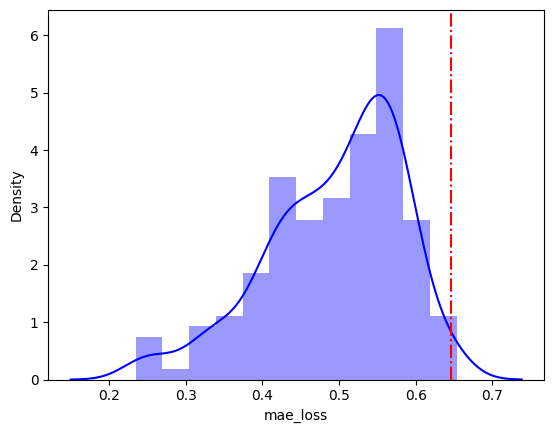

In [13]:
try:
    machine_number = 13
    test_data = make_prediction_data(machine_number)
    UniqeNumAndCavity = test_data['UniqeNumAndCavity'].iloc[-1]
    PredictionNeonent(machine_number,UniqeNumAndCavity)
    monitor()
except:
    pass

#### Ex.) 사출기 14호 UniqueNum 250429161242700-4에 대한 예측 결과 설명 
- Fixed & Adaptable Hybrid Anomaly Detection으로 최종 Normal로 예측 
- 실시간 전체 정상/불량 예측은 612/8개로 예측
- 이후 Recheck Anomalies 과정에서 8개 불량에 대한 실시간 620개의 Test MAE Loss의 공정능력지수, Fault 기반 Robust Z-score 등을 활용한 검토
- 만약 현재 UniqueNum이 250429140912023-1였으면 확실히 불량 품질로 파정 가능 

2025-04-29 13:00:29.908000 ~ 2025-04-29 16:12:43.768000
2025-04-29 13:00:29.908000 ~ 2025-04-29 16:12:43.768000
Distribution Stable ==> Activate Hybrid Anomaly Detection
UniqueCavityNumber ==> 250429161242700-4
Update Trained Normal Data
Run Fixed Prediction
fixed threshold 0.36
trained scaled mae loss 0.059
Optimized Threshold Percentile ==> 98.5650464998012
prediction
1    612
0      8
Name: count, dtype: int64
UniqueCavityNumber ==> 250429161242700-4
adaptable threshold 0.53
real time scaled mae loss 0.321
Prediction Result = Normal
공정능력지수 ==> cp:0.943,cpk: 0.797
Recheck Anomaly Preds
prediction
1    612
0      8
Name: count, dtype: int64
Prediction Result = Normal
Optimized Threshold Percentile ==> 98.5480091479318
공정능력지수 ==> cp:0.933,cpk: 0.776
Recheck Anomaly Preds
prediction
0    8
Name: count, dtype: int64


,Working_No_Origin,UniqeNumAndCavity,Value1,Value2,Value3,Value4,PassOrFail,mae_loss,threshold,anomaly,prediction,robust_z_score,mae_diff
204,250429140419870,250429140419870-3,62.6,58.5,77.8,58.2,0,0.597116,0.523942,True,0,2.780155,0.073173
205,250429140419870,250429140419870-4,62.6,58.5,77.8,58.2,0,0.597116,0.523942,True,0,2.780155,0.073173
206,250429140419870,250429140419870-2,62.6,58.5,77.8,58.2,0,0.597116,0.523942,True,0,2.780155,0.073173
207,250429140419870,250429140419870-1,62.6,58.5,77.8,58.2,0,0.597116,0.523942,True,0,2.780155,0.073173
220,250429140912023,250429140912023-2,62.8,58.6,77.9,58.4,0,0.568952,0.523942,True,0,2.509396,0.045009
221,250429140912023,250429140912023-3,62.8,58.6,77.9,58.4,0,0.568952,0.523942,True,0,2.509396,0.045009
222,250429140912023,250429140912023-4,62.8,58.6,77.9,58.4,0,0.568952,0.523942,True,0,2.509396,0.045009
223,250429140912023,250429140912023-1,62.8,58.6,77.9,58.4,0,0.568952,0.523942,True,0,2.509396,0.045009


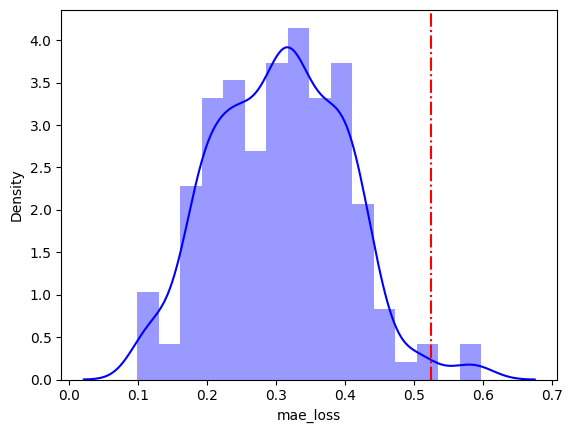

In [14]:
try:
    machine_number = 14
    test_data = make_prediction_data(machine_number)
    UniqeNumAndCavity = test_data['UniqeNumAndCavity'].iloc[-1]
    PredictionNeonent(machine_number,UniqeNumAndCavity)
    monitor()
except:
    pass